In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))
from collections import defaultdict

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torchvision import transforms

from Code.dataset_helpers import get_dataset, get_data_loader
from Code.network.vgg_backbone import initialize_vgg_attn_prototype, initialize_vgg_attn 
from Code.network.resnet_backbone import initialize_LResNet50_attn
from Code.network.classifier import MarginCosineProduct
from eval_net import extract_feature

## MNIST Occlusion Dataset

In [ ]:
# device
device = 'cuda'

# test data path
root = '../dataset/MNIST_224X224_3'
test_data = 'test_occ_black'
annot_file = 'pairs_test.txt'

# model weight path
model_weight = 'results/vgg16_attn_prototype/epoch_10.pt'
prototype_weight = 'prototype_weight/prototype_vgg16.pkl'
feature_dict = 'feature_dictionary/MNIST/dictionary_mnist_VGG_pool4_K512_vMFMM30.pickle'

In [ ]:
# load the pretrain model
model = initialize_vgg_attn_prototype(prototype_weight, feature_dict, num_classes = 10)
model.load_state_dict(torch.load(model_weight))

# create test loader
transform = transforms.Compose([
    transforms.ToTensor()
])

MNIST_test_occ, _ = get_dataset(
    root,
    test_data,
    annot_file,
    transform
)

test_loader = iter(get_data_loader(MNIST_test_occ, batch_size = 1))

In [ ]:
def predict(model, image, device = 'cpu', with_predictions = True):
    model.to(device)
    model.eval()
    image = image.to(device)
    prediction = None
    
    with torch.no_grad():
        score, additional_loss, additional_output = model(image)
        
        if with_predictions:
            score_prob = F.softmax(score['score'], dim = 1)
            prediction = torch.max(score_prob, dim = 1).indices.to('cpu')
        
        attn_before = additional_output['attn_map'][0]
        attn_after = additional_output['attn_map'][-1]
    
    return prediction, attn_before, attn_after

In [ ]:
to_PIL = transforms.Compose([
    transforms.ToPILImage()
])

data, label = next(test_loader)
img = to_PIL(torch.squeeze(data.detach().clone()))

# make predictions
pred, attn_pool4 = predict(model, data, device = device)
attn_pool4 = torch.squeeze(attn_pool4).numpy()

# visualize the result
fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(img, aspect='auto')
ax[0].set_title(f'Class {label.item()}')

sns.heatmap(attn_pool4, cmap = 'coolwarm', ax = ax[1], cbar = False)
ax[1].set_title(f'Prediction: {pred.item()}')

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.show()

## CASIA-Webface Dataset

In [ ]:
# device
device = 'cpu'

# test data path
root = '../dataset'
images = 'CASIA_aligned'
annot_file = 'CASIA_aligned_list.txt'

# weight path
model_weight = 'results/vgg16_128_last_attn_casia/epoch_21.pt'
classifier_weight = 'results/vgg16_128_last_attn_casia/mcp_epoch_21.pt'
feature_dict = 'feature_dictionary/CASIA/100000/dictionary_second_64.pickle'

In [ ]:
def predict(model, classifier, image, device = 'cpu'):
    model.to(device)
    model.eval()
    
    classifier.to(device)
    classifier.eval()
    
    image = image.to(device)
    
    with torch.no_grad():
        feature, additional_loss, additional_output = model(image)
        score = classifier(feature['features'], label)
        
        score_prob = F.softmax(score, dim = 1)
        prediction = torch.max(score_prob, dim = 1).indices.to('cpu')
        
        attn_before = additional_output['attn_map'][0]
        attn_after = additional_output['attn_map'][-1]
    
    return prediction, attn_before, attn_after

In [ ]:
# define transformation
transform_face = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

face_model = initialize_vgg_attn(128, feature_dict)
face_model.load_state_dict(torch.load(model_weight))
# face_model.load_feature_dict(feature_dict)
mcp = MarginCosineProduct(512, 10575)
mcp.load_state_dict(torch.load(classifier_weight))

CASIA_dataset, _ = get_dataset(
    root,
    images,
    annot_file,
    transform_face,
    mode = 'annotation'
)

CASIA_loader = iter(get_data_loader(CASIA_dataset, batch_size = 1))

In [ ]:
to_PIL = transforms.Compose([
    transforms.Normalize(mean = (0, 0, 0), std = (1/0.5, 1/0.5, 1/0.5)),
    transforms.Normalize(mean = (-0.5, -0.5, -0.5), std = (1, 1, 1)),
    transforms.ToPILImage()
])

data, label = next(CASIA_loader)
img = to_PIL(torch.squeeze(data.detach().clone()))

# make predictions
pred, attn_before, attn_after = predict(face_model, mcp, data, device = device)
attn_before = torch.squeeze(attn_before).numpy()
attn_after = torch.squeeze(attn_after).numpy()

# visualize the result
fig, ax = plt.subplots(1,3, figsize = (18,6))
ax[0].imshow(img, aspect='auto')
ax[0].set_title(f'Class {label.item()}')

sns.heatmap(attn_before, cmap = 'coolwarm', ax = ax[1], cbar = False)
ax[1].set_title('Attention Map Before FM')

sns.heatmap(attn_after, cmap = 'coolwarm', ax = ax[2], cbar = False)
ax[2].set_title('Attention Map After FM')

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.show()

print("Prediction:", pred)

### Good Predictions

In [ ]:
num_images = 8
good_images = []

while len(good_images) < num_images:
    data, label = next(CASIA_loader)
    img = to_PIL(torch.squeeze(data.detach().clone()))
    
    pred, attn_before, attn_after = predict(face_model, mcp, data, device = device)
    attn_before = torch.squeeze(attn_before).numpy()
    attn_after = torch.squeeze(attn_after).numpy()
    
    if pred.item() == label.item():
        good_images.append([img, attn_after])

# visualize 4×4 grid
plt.figure(figsize=(16,16))
for i in range(1, 17, 2):
    ax = plt.subplot(4,4,i)
    ax.imshow(good_images[i//2][0])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    
    ax = plt.subplot(4,4,i+1)
    sns.heatmap(good_images[i//2][1], cmap = 'coolwarm', ax = ax, cbar = False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Bad Predictions

In [ ]:
num_images = 8
bad_images = []

while len(good_images) < num_images:
    data, label = next(CASIA_loader)
    img = to_PIL(torch.squeeze(data.detach().clone()))
    
    pred, attn_before, attn_after = predict(face_model, mcp, data, device = device)
    attn_before = torch.squeeze(attn_before).numpy()
    attn_after = torch.squeeze(attn_after).numpy()
    
    if pred.item() != label.item():
        bad_images.append([img, attn_after])

# visualize 4×4 grid
plt.figure(figsize=(16,16))
for i in range(1, 17, 2):
    ax = plt.subplot(4,4,i)
    ax.imshow(bad_images[i//2][0])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    
    ax = plt.subplot(4,4,i+1)
    sns.heatmap(bad_images[i//2][1], cmap = 'coolwarm', ax = ax, cbar = False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Masked LFW Dataset

In [26]:
# device
device = 'cuda'
root = os.path.join(os.getcwd(), "..")

# test data path
dataset_root = os.path.join(root, 'dataset/LFW_pairs_aligned')
test_data = 'Combined'
annot_file = 'pairs_masked.txt'

# weight path
model_type = "resnet_attn"
model_weight = 'results/resnet_64_second_attn_casia/epoch_2.pt'
feature_dict = 'feature_dictionary/CASIA/100000/dictionary_second_64.pickle'

# threshold
good_thresh = 0.75
bad_thresh = 0.42

In [16]:
def read_pairs(root, filelist):
    with open(os.path.join(root, filelist), 'r') as f:
        pairs_lines = f.readlines()[:]
    
    return pairs_lines


def get_pairs_images(pair_line, file_ext = ''):
    pair_line = pair_line.replace('\n', '').split()
  
    if len(pair_line) == 3:
        if os.path.splitext(pair_line[0])[1] in ['.jpg', '.png'] and os.path.splitext(pair_line[1])[1] in ['.jpg', '.png']:
            filename1 = pair_line[0]
            filename2 = pair_line[1]
        else:
            # same identity
            fileid1 = '0' * (4 - len(str(pair_line[1])) ) + str(pair_line[1])
            fileid2 = '0' * (4 - len(str(pair_line[2])) ) + str(pair_line[2])
            filename1 = f'{pair_line[0]}_' + fileid1 + file_ext + '.jpg'
            filename2 = f'{pair_line[0]}_' + fileid2 + file_ext + '.jpg'
    elif len(pairs) == 4:
        # different identity
        fileid1 = '0' * (4 - len(str(pair_line[1])) ) + str(pair_line[1])
        fileid2 = '0' * (4 - len(str(pair_line[3])) ) + str(pair_line[3])
        filename1 = f'{pair_line[0]}_' + fileid1 + file_ext + '.jpg'
        filename2 = f'{pair_line[2]}_' + fileid2 + file_ext + '.jpg'
        
    return filename1, filename2


def get_masked_pairs(pair_line, file_ext = ''):
    pair_line = pair_line.replace('\n', '').split()
    mask_exist = False
    
    masked_file = ori_file = pair_line[1]
    if masked_file.split('_')[-1] in ['cloth.jpg', 'KN95.jpg', 'N95.jpg']:
        ori_file = '_'.join(masked_file.split('_')[:-1]) + '.jpg'
        mask_exist = True
        
    return ori_file, masked_file, mask_exist


def predict(model, image, device = 'cpu'):
    model.to(device)
    model.eval()
    
    image = image.to(device)
    
    with torch.no_grad():
        feature, additional_loss, additional_output = model(image)
        
        attn_before = additional_output['attn_map'][0]
        attn_after = additional_output['attn_map'][-1]
        sim_cluster = additional_output['similar_cluster']
    
    return feature, {"attn_before": attn_before, "attn_after": attn_after, "similar_cluster": sim_cluster}

In [17]:
# define transformation
transform_face = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

pairs = read_pairs(dataset_root, annot_file)

if model_type == "vgg_attn":
    face_model = initialize_vgg_attn(64, os.path.join(root, feature_dict))
elif model_type == "resnet_attn":
    face_model = initialize_LResNet50_attn(64, os.path.join(root, feature_dict))
face_model.load_state_dict(torch.load(os.path.join(root, model_weight)))
# face_model.load_feature_dict(feature_dict)
face_model.requires_grad_ = False
face_model.eval();

# _, attn_pool4 = predict(model, )


Load feature dictionary from: /home/user/Final_Year_Project/TDMPNet/notebooks/../feature_dictionary/CASIA/100000/dictionary_second_64.pickle
Feature dictionary shape: (64, 256, 1, 1)


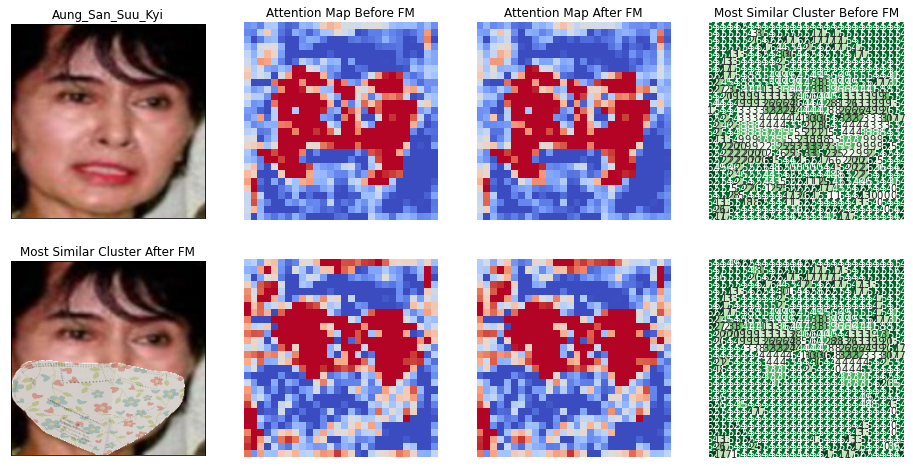

In [22]:
sample_idx = np.random.randint(len(pairs), size = 1)[0]

sample_pairs = pairs[sample_idx]
filename1, filename2, _ = get_masked_pairs(sample_pairs)

img1 = Image.open(os.path.join(dataset_root, test_data, filename1)).convert('RGB')
img2 = Image.open(os.path.join(dataset_root, test_data, filename2)).convert('RGB')

tensor_img1 = transform_face(img1).unsqueeze(0)
tensor_img2 = transform_face(img2).unsqueeze(0)

_, outputs1 = predict(face_model, tensor_img1, device = device)
attn_before1 = torch.squeeze(outputs1["attn_before"]).numpy()
attn_after1 = torch.squeeze(outputs1["attn_after"]).numpy()
sim_cluster_before = torch.squeeze(outputs1["similar_cluster"][0]).numpy()
sim_cluster_after = torch.squeeze(outputs1["similar_cluster"][1]).numpy()

_, outputs2 = predict(face_model, tensor_img2, device = device)
attn_before2 = torch.squeeze(outputs2["attn_before"]).numpy()
attn_after2 = torch.squeeze(outputs2["attn_after"]).numpy()
sim_cluster_before2 = torch.squeeze(outputs2["similar_cluster"][0]).numpy()
sim_cluster_after2 = torch.squeeze(outputs2["similar_cluster"][1]).numpy()

# visualize the result
id_name1 = filename1.split('_0')[0]
id_name2 = filename2.split('_0')[0]

fig, ax = plt.subplots(2,4, figsize = (16,8))
ax = ax.flat

data = [[img1, attn_before1, attn_after1 , sim_cluster_after], 
        [img2, attn_before2, attn_after2, sim_cluster_after2]]

for i in range(0, 8, 4):
    ax[i].imshow(data[i//3][0])
    
    sns.heatmap(data[i//3][1], cmap = 'coolwarm', ax = ax[i+1], cbar = False)
    sns.heatmap(data[i//3][2], cmap = 'coolwarm', ax = ax[i+2], cbar = False)
    
    sns.heatmap(data[i//3][3], cmap = 'Greens', ax = ax[i+3], cbar = False, annot = True)

ax[0].set_title(id_name1)
ax[1].set_title("Attention Map Before FM")
ax[2].set_title("Attention Map After FM")
ax[3].set_title("Most Similar Cluster Before FM")
ax[4].set_title("Most Similar Cluster After FM")

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.show()

### Good Predictions

Cosine similarity:  0.772648274898529
Cosine similarity:  0.760400652885437
Cosine similarity:  0.7762483954429626
Cosine similarity:  0.7726948857307434


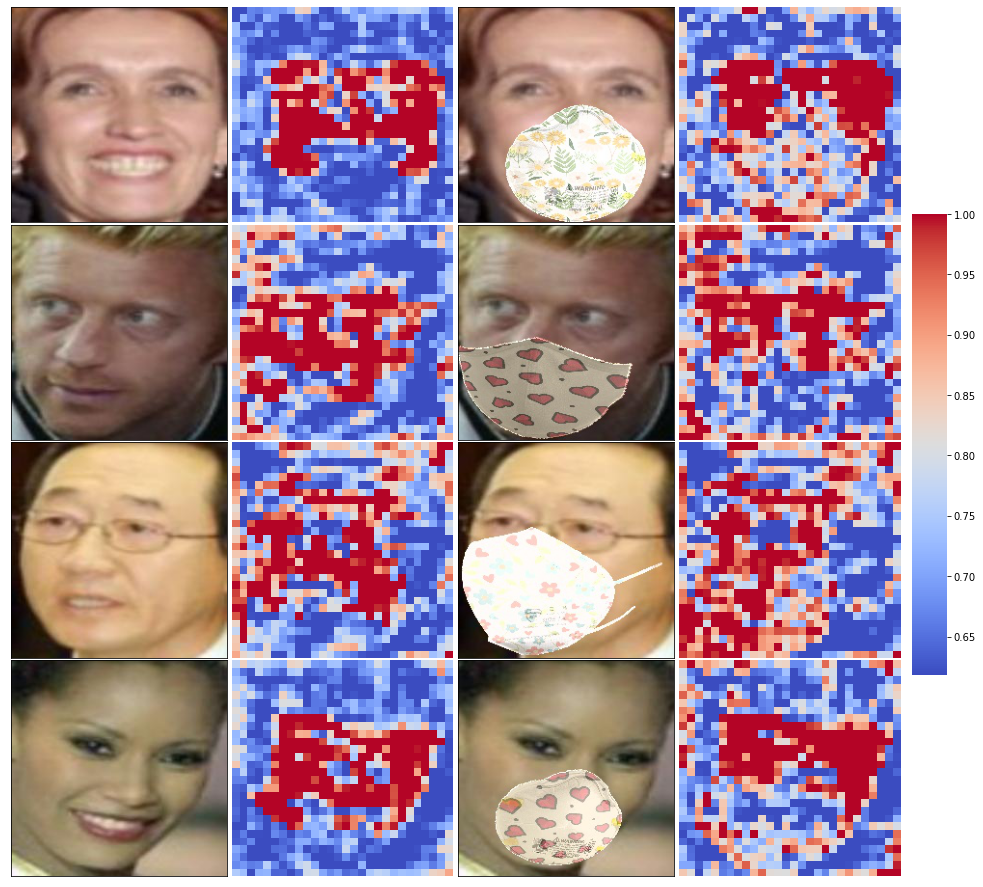

In [27]:
num_cases = 4
good_preds = []
identity_record = defaultdict(lambda: False) # dictionary to handle duplicate images

for idx in range(len(pairs)):
    one_pairs = pairs[idx]
    filename1, filename2, mask_exist = get_masked_pairs(one_pairs)

    # only get the mask and unmasked pairs
    if not mask_exist:
        continue

    img1 = Image.open(os.path.join(dataset_root, test_data, filename1)).convert('RGB')
    img2 = Image.open(os.path.join(dataset_root, test_data, filename2)).convert('RGB')

    tensor_img1 = transform_face(img1).unsqueeze(0)
    tensor_img2 = transform_face(img2).unsqueeze(0)

    with torch.no_grad():
        _, outputs1 = predict(face_model, tensor_img1, device = device)
        attn_after1 = torch.squeeze(outputs1["attn_after"]).numpy()
        feat1 = extract_feature(img1, face_model, device = device)

        _, outputs2 = predict(face_model, tensor_img2, device = device)
        attn_after2 = torch.squeeze(outputs2["attn_after"]).numpy()
        feat2 = extract_feature(img2, face_model, device = device)

        dist = feat1.dot(feat2) / (feat1.norm() * feat2.norm() + 1e-5)
    
    if dist >= good_thresh and not identity_record[filename1]:
        print("Cosine similarity: ", dist.item())
        good_preds.append([img1, attn_after1, img2, attn_after2])
        identity_record[filename1] = True
    
    if len(good_preds) == num_cases:
        break


# visualize 4×4 grid
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 4):
    ax[i].imshow(good_preds[i//4][0])
    ax[i+2].imshow(good_preds[i//4][2])
    
    sns.heatmap(good_preds[i//4][1], cmap = 'coolwarm', ax = ax[i+1], cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax)
    sns.heatmap(good_preds[i//4][3], cmap = 'coolwarm', ax = ax[i+3], cbar = False, cbar_ax = None)

for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
plt.show()

# save the image
save_dir = os.path.join(root, "visualization")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "lfw_masked_good.jpg"))

### Bad Predictions

Cosine similarity:  0.3648814260959625
Cosine similarity:  0.4145659804344177
Cosine similarity:  0.37251046299934387
Cosine similarity:  0.3867798149585724


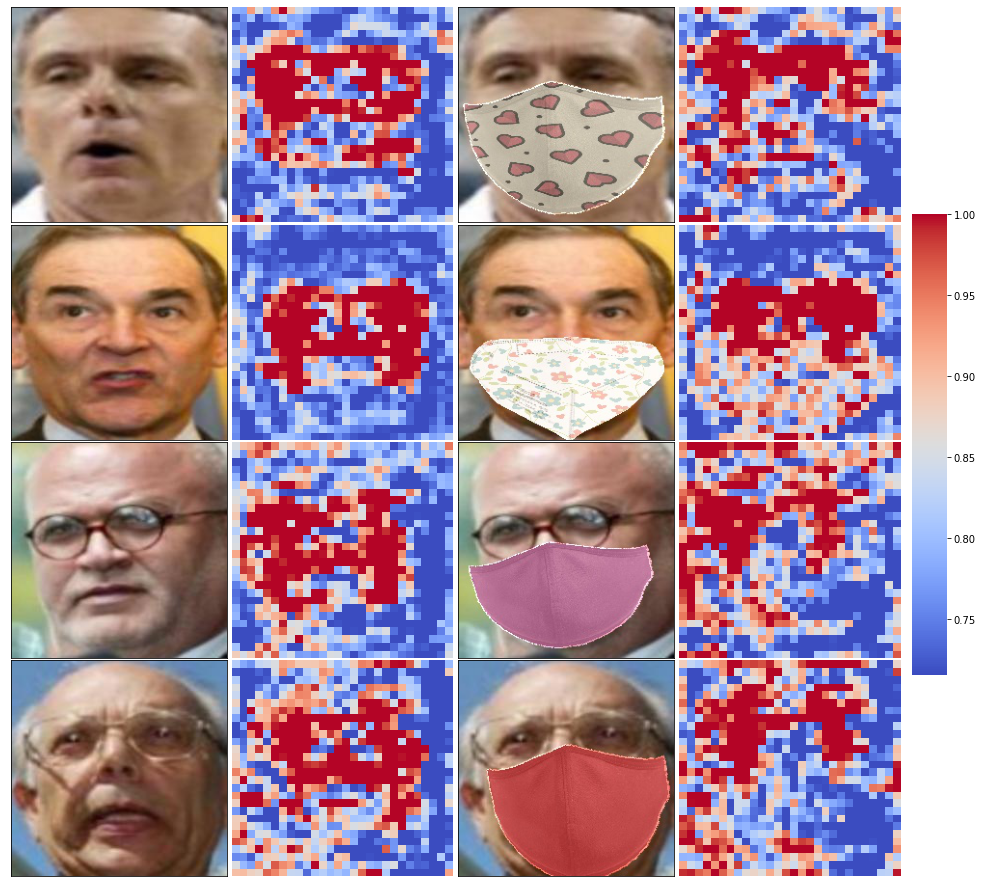

In [28]:
num_cases = 4
bad_preds = []
identity_record = defaultdict(lambda: False)

for idx in range(len(pairs)):
    one_pairs = pairs[idx]
    filename1, filename2, mask_exist = get_masked_pairs(one_pairs)

    # only get the mask and unmasked pairs
    if not mask_exist:
        continue

    img1 = Image.open(os.path.join(dataset_root, test_data, filename1)).convert('RGB')
    img2 = Image.open(os.path.join(dataset_root, test_data, filename2)).convert('RGB')

    tensor_img1 = transform_face(img1).unsqueeze(0)
    tensor_img2 = transform_face(img2).unsqueeze(0)

    with torch.no_grad():
        _, outputs1 = predict(face_model, tensor_img1, device = device)
        attn_after1 = torch.squeeze(outputs1["attn_after"]).numpy()
        feat1 = extract_feature(img1, face_model, device = device)

        _, outputs2 = predict(face_model, tensor_img2, device = device)
        attn_after2 = torch.squeeze(outputs2["attn_after"]).numpy()
        feat2 = extract_feature(img2, face_model, device = device)

        dist = feat1.dot(feat2) / (feat1.norm() * feat2.norm() + 1e-5)
    
    if dist <= bad_thresh and not identity_record[filename1]:
        print("Cosine similarity: ", dist.item())
        bad_preds.append([img1, attn_after1, img2, attn_after2])
        identity_record[filename1] = True
    
    if len(bad_preds) == num_cases:
        break


# visualize 4×4 grid
fig, ax = plt.subplots(4, 4, figsize = (16,16))
ax = ax.flat
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(0, 16, 4):
    ax[i].imshow(bad_preds[i//4][0])
    ax[i+2].imshow(bad_preds[i//4][2])
    
    sns.heatmap(bad_preds[i//4][1], cmap = 'coolwarm', ax = ax[i+1], cbar = i+1 == 1, cbar_ax = None if i+1 != 1 else cbar_ax)
    sns.heatmap(bad_preds[i//4][3], cmap = 'coolwarm', ax = ax[i+3], cbar = False, cbar_ax = None)

for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
    
plt.subplots_adjust(wspace = 0.01, hspace = 0.01)
plt.show()

# save the image
save_dir = os.path.join(root, "visualization")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fig.savefig(os.path.join(save_dir, "lfw_masked_bad.jpg"))